In [1]:
# Setup of libraries, mounting the Google Drive etc.

import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf

import utils
import IPython

print('The current working directory is:', os.getcwd())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The current working directory is: /content/gdrive/My Drive/Colab Notebooks


## Read the dataset from `.pkl` file


In [2]:
df = pd.read_pickle('datasets/cabspotting.pkl')
df.head()

latitude  longitude  occupied
user   time                                              
abboip 2008-05-17 14:12:10  37.75153 -122.39447         0
       2008-05-17 14:13:34  37.75149 -122.39447         0
       2008-05-17 14:14:34  37.75149 -122.39447         0
       2008-05-17 14:15:35  37.75149 -122.39446         0
       2008-05-17 14:41:43  37.75144 -122.39449         0

## Convert the dataset to a mapping of users to the strings of their movements

In [3]:
df = utils.records_to_user_geolcation(df)
df.head()

user
abboip      [[15126.000000000002, -122.39447, 37.751529999...
abcoij      [[47486.0, -122.41466000000001, 37.80346], [47...
abdremlu    [[11949.0, -122.39093000000001, 37.75521], [12...
abgibo      [[16.0, -122.4374, 37.7733], [61.0000000000000...
abjoolaw    [[13856.0, -122.39747, 37.75159], [13916.0, -1...
dtype: object

## Split the data into training and test/validation sets
Keep the data of 10 users from the networks during traing in order to 'visually' validate that the network is working later on.

In [4]:
len(df)

536

In [5]:
df_train = df.iloc[:len(df) - 10]
df_test = df.iloc[len(df) - 10:]

print('Train:', len(df_train))
print('Test:', len(df_test))

Train: 526
Test: 10


## Make one single sequence to train on from the training data

In [0]:
data_train = utils.user_geolocation_to_single_sequence(df_train)

In [7]:
data_train

array([[ 1.5126000e+04, -1.2239447e+02,  3.7751530e+01],
       [ 1.5210000e+04, -1.2239447e+02,  3.7751490e+01],
       [ 1.5270000e+04, -1.2239447e+02,  3.7751490e+01],
       ...,
       [ 2.0688330e+06, -1.2241069e+02,  3.7792440e+01],
       [ 2.0688930e+06, -1.2241165e+02,  3.7792150e+01],
       [ 2.0689140e+06, -1.2241172e+02,  3.7792120e+01]])

In [8]:
data_train.shape

(11021539, 3)

## Create the scaler on the training data
The sequence for the generator is used to fit a `StandardScaler` to the training data.
This scaler should later be saved alongside the trained model, as the scaler should only be fitted to the training data and the training data changes on every execution of this Notebook.

In [9]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(data_train)

print('Means: %f %f %f' % (scaler.mean_[0], scaler.mean_[1], scaler.mean_[2]))
print('Standard deviations: %f %f %f' % (scaler.var_[0], scaler.var_[1], scaler.var_[2]))

Means: 1017898.964911 -122.412463 37.763528
Standard deviations: 345921612396.343018 0.001279 0.002907


## Build the generator

In [0]:
# Inputs
sequence_input = tf.keras.layers.Input(shape=(None, 3), name='sequence_input')
random_input = tf.keras.layers.Input(shape=(32,), name='random_input')

# Recurrent part
recurrent = tf.keras.layers.GRU(256)(sequence_input)

# Add random variation
x = tf.keras.layers.concatenate([recurrent, random_input])
prediction = tf.keras.layers.Dense(3)(x)

# Create the model
generator = tf.keras.models.Model(inputs=[sequence_input, random_input], outputs=prediction)

In [11]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, None, 3)      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 256)          199680      sequence_input[0][0]             
__________________________________________________________________________________________________
random_input (InputLayer)       (None, 32)           0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 288)          0           gru[0][0]                        
                                                                 random_input[0][0]               
__________

In [12]:
generator.input_shape

[(None, None, 3), (None, 32)]

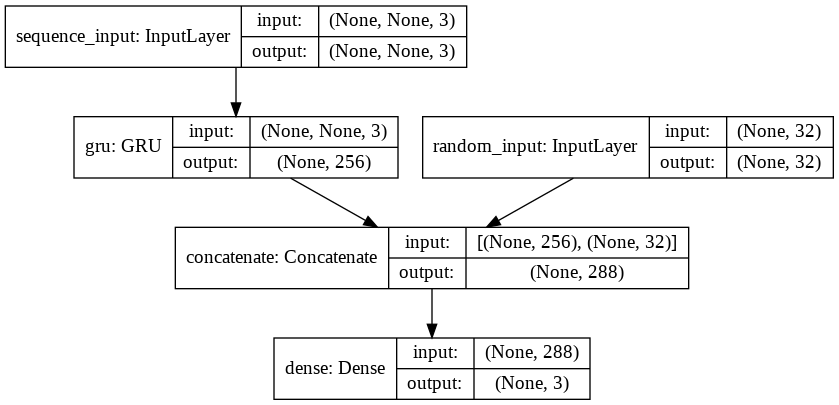

In [43]:
tf.keras.utils.plot_model(generator, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

## Build the discriminator

In [0]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(None, 3)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               50688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 50,817
Trainable params: 50,817
Non-trainable params: 0
_________________________________________________________________


In [15]:
discriminator.input_shape

(None, None, 3)

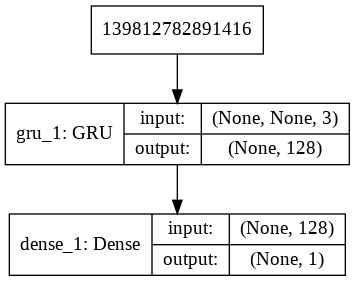

In [42]:
tf.keras.utils.plot_model(discriminator, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

## Put the adversarial model together

In [0]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
discriminator.trainable = False

g_out = generator([sequence_input, random_input])
g_out = tf.keras.layers.Reshape((1, 3))(g_out)
d_in = tf.keras.layers.Concatenate(axis=1)([sequence_input, g_out])
d_out = discriminator(d_in)

adversarial = tf.keras.models.Model(inputs=[sequence_input, random_input], outputs=d_out)

adversarial.compile(optimizer='adam', loss='binary_crossentropy')

In [31]:
adversarial.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, None, 3)      0                                            
__________________________________________________________________________________________________
random_input (InputLayer)       (None, 32)           0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 3)            200547      sequence_input[0][0]             
                                                                 random_input[0][0]               
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 3)         0           model[13][0]                     
__________

In [32]:
adversarial.input_shape

[(None, None, 3), (None, 32)]

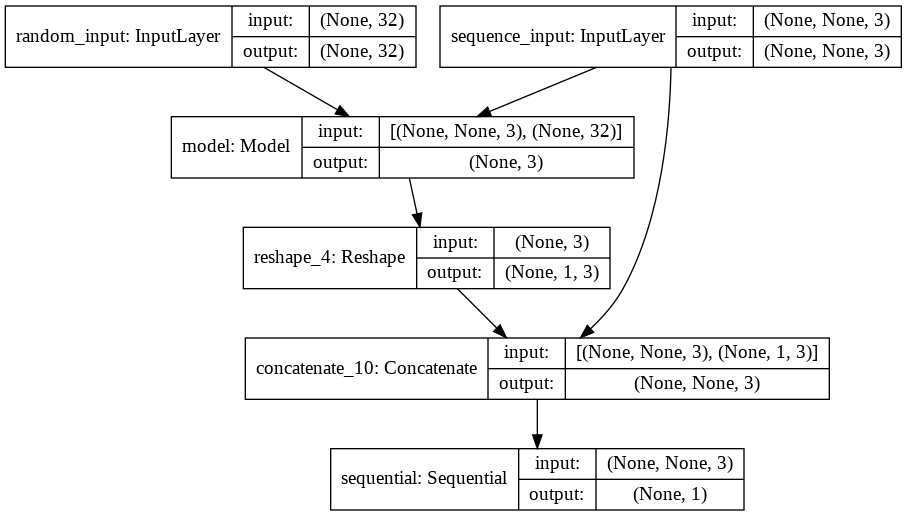

In [40]:
tf.keras.utils.plot_model(adversarial, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

## Training
**REMEMBER:** The `BATCH_SIZE` of the Recurrent GAN has a very different meaning to that of the simple RNN. Instead of number of sequences, here it is more like number of users / user trajectories.

In [0]:
EPOCHS = 30
BATCH_SIZE = 20

n_batches = len(df_train) // BATCH_SIZE + 1

for epoch in range(EPOCHS):
    for batch in range(n_batches):
        
        # --- PART 1: Train the discriminator ----------------------------------
        
        # Use the generator to generate a half a batch full of fake data
        fake_data = []
        for i in range(BATCH_SIZE // 2):
            length = df_train.sample(1).squeeze().shape[0]
            start = data_train[np.random.randint(data_train.shape[0])]
            
            generated = np.array([start])
            
            generator.reset_states()
            
            for i in range(1, length):
                input = generated[-1:]
                input = np.array([input])
                
                prediction = model.predict(input, batch_size=1)
                
                prediction = np.squeeze(prediction, axis=0)
                generated = np.concatenate([generated, prediction])
            
            fake_data.append(generated)
        
        fake_labels = np.zeros((BATCH_SIZE // 2, 1))
        
        # Get half a batch of real data
        real_data = df_train.iloc[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE].tolist()
        real_labels = np.ones((BATCH_SIZE // 2, 1))
        
        # Train the discriminator on half a batch of real and half a batch of fake data
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
        
        # --- PART 2: Train the generator --------------------------------------
        g_loss = adversarial_model.train_on_batch(noise, np.ones((batch_size, 1)))

## Save and plot the history
The history holds information on loss and validiation loss during training.

## Load and prepare the trained model for generating data

## Generate geolocation data of one entity using the trained model
In the end the generated data is saved to disk in order to be reused from a different notebook.

In [0]:
N_GENERATE = 1000

start = [324.0, -122.390085, 37.789910]    # Google Offices in San Francisco: 37.789910, -122.390085
generated = np.array([start]).astype(np.float32)

model.reset_states()

for i in range(1, N_GENERATE):
    input = generated[-1:]
    input = scaler.transform(input)
    input = np.array([input])
    
    prediction = model.predict(input, batch_size=1)
    
    prediction = np.squeeze(prediction, axis=0)
    prediction = scaler.inverse_transform(prediction)
    
    generated = np.concatenate([generated, prediction])

In [0]:
generated.shape

In [0]:
generated

In [0]:
with open('generated/citybased_gan/test_00.pkl', 'wb') as file:
    pickle.dump(generated, file)
    print('Generated data saved')